In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

In [2]:
p_project = str(pathlib.Path(os.getcwd()).parents[1])
path_eicu = p_project + '/data/eicu'
path_processed = path_eicu/"processed"
path_data = path_processed/"all_data.csv"
path_pat = path_eicu/"raw/eicu-2.0/patient.csv.gz"

In [3]:
all_df = pd.read_csv(path_data).rename(columns={'patientunitstayid': 'ID', 'itemoffset': 'Time'}).set_index('ID')

In [4]:
all_df.head()

,Time,FiO2,GCS Total,Heart Rate,Invasive BP Diastolic,Invasive BP Systolic,O2 Saturation,Respiratory Rate,Temperature (C),glucose,pH,Motor,Eyes,MAP (mmHg),Verbal
ID,,,,,,,,,,,,,,,
1578183,4,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1578183,13,NaN,NaN,73.0,84.0,181.0,100.0,17.0,34.722222,NaN,NaN,NaN,NaN,NaN,NaN
1578183,19,NaN,4.0,75.0,154.0,188.0,100.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1578183,34,NaN,4.0,73.0,86.0,208.0,100.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1578183,49,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
var_to_consider = ['glucose', 'Invasive BP Diastolic', 'Invasive BP Systolic',
                   'O2 Saturation', 'Respiratory Rate', 'Motor', 'Eyes', 'MAP (mmHg)',
                   'Heart Rate', 'GCS Total', 'Verbal', 'pH', 'FiO2', 'Temperature (C)']

cols_needed = var_to_consider + ['Time']
for col_name in all_df.columns:
    if not col_name in cols_needed:
        all_df.drop(col_name, axis=1, inplace=True)

In [6]:
all_df.shape

(8478327, 15)

In [7]:
all_df = all_df[(all_df['Time']>=0) & (all_df['Time']<2880)]

In [8]:
all_df.shape

(3334730, 15)

In [9]:
tmp_df = all_df.groupby('ID').size()

<AxesSubplot: >

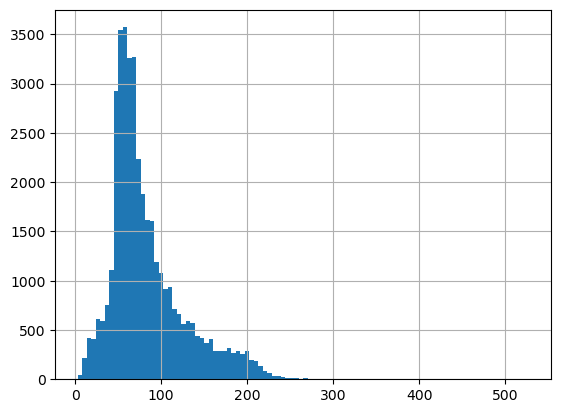

In [10]:
tmp_df.hist(bins=100)

In [11]:
tmp_df.describe()

count    40005.000000
mean        83.357830
std         43.954611
min          3.000000
25%         55.000000
50%         70.000000
75%        101.000000
max        527.000000
dtype: float64

In [12]:
ids_before = all_df.loc[all_df['Time'] < 1440].groupby('ID').size()
ids_after = all_df.loc[all_df['Time'] > 1440].groupby('ID').size()

In [13]:
ids_before_selected = ids_before.loc[ids_before >= 30].index
ids_after_selected = ids_after.loc[ids_after >= 30].index

print("ids_before_selected: ", ids_before_selected.shape)
print("ids_after_selected: ", ids_after_selected.shape)

ids_before_selected:  (30389,)
ids_after_selected:  (18569,)


In [14]:
df_var_num = all_df.iloc[:, 1:].notna().groupby("ID").apply(lambda x: x.sum(axis=0).gt(0).sum())

<AxesSubplot: >

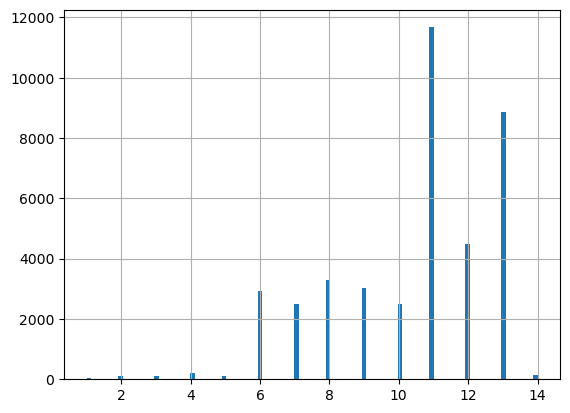

In [15]:
df_var_num.hist(bins=100)

In [16]:
ids_selected_by_vars = df_var_num.loc[df_var_num >= 10].index

print("ids_selected_by_vars: ", ids_selected_by_vars.shape)

ids_selected_by_vars:  (27673,)


In [17]:
ids_selected = set(ids_before_selected) & set(ids_after_selected) & set(ids_selected_by_vars)
len(ids_selected)

12312

In [18]:
all_df = all_df.loc[all_df.index.isin(ids_selected)]

In [19]:
# Create a label code (int) for the labels.
label_dict = dict(zip(var_to_consider, ("Value_" + str(i) for i in range(len(var_to_consider)))))
all_df.rename(label_dict, axis=1, inplace=True)

In [20]:
all_df.head()

,Time,Value_12,Value_9,Value_8,Value_1,Value_2,Value_3,Value_4,Value_13,Value_0,Value_11,Value_5,Value_6,Value_7,Value_10
ID,,,,,,,,,,,,,,,
1578183,4,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1578183,13,NaN,NaN,73.0,84.0,181.0,100.0,17.0,34.722222,NaN,NaN,NaN,NaN,NaN,NaN
1578183,19,NaN,4.0,75.0,154.0,188.0,100.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1578183,34,NaN,4.0,73.0,86.0,208.0,100.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1578183,49,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_value = all_df.iloc[:, 1:]

arr_mask = (~np.isnan(df_value.values)).astype(float)

df_mask = pd.DataFrame(arr_mask, columns=['Mask_'+i_str[6:] for i_str in df_value.columns.tolist()], index=all_df.index)

df_eicu_data = pd.concat([all_df.fillna(0), df_mask], axis=1)


In [22]:
df_eicu_data.head()

,Time,Value_12,Value_9,Value_8,Value_1,Value_2,Value_3,Value_4,Value_13,Value_0,...,Mask_2,Mask_3,Mask_4,Mask_13,Mask_0,Mask_11,Mask_5,Mask_6,Mask_7,Mask_10
ID,,,,,,,,,,,,,,,,,,,,,
1578183,4,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1578183,13,0.0,0.0,73.0,84.0,181.0,100.0,17.0,34.722222,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1578183,19,0.0,4.0,75.0,154.0,188.0,100.0,20.0,0.000000,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1578183,34,0.0,4.0,73.0,86.0,208.0,100.0,15.0,0.000000,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1578183,49,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
pat_df = pd.read_csv(path_pat)

In [24]:
labels_mortality = pat_df[pat_df['hospitaldischargestatus'].isin(['Expired', 'Alive'])][['patientunitstayid', 'hospitaldischargestatus']]

labels_mortality['hospitaldischargestatus'] = labels_mortality['hospitaldischargestatus'].replace({"Expired": 1, "Alive": 0})

labels_mortality.rename(columns={'patientunitstayid': 'ID', 'hospitaldischargestatus': 'labels'}, inplace=True)

In [25]:
labels_mortality = labels_mortality[labels_mortality['ID'].isin(df_eicu_data.index)]
df_eicu_data = df_eicu_data[df_eicu_data.index.isin(labels_mortality['ID'])]

In [26]:
labels_mortality.shape

(12312, 2)

In [27]:
df_eicu_data.to_csv(path_processed/'eicu_data.csv')
labels_mortality.to_csv(path_processed/'eicu_labels.csv', index=False)

In [28]:
df_eicu_data[['Value_7', 'Value_8', 'Mask_7', 'Mask_8']].tail()

,Value_7,Value_8,Mask_7,Mask_8
ID,,,,
2054261,0.0,113.0,0.0,1.0
2054261,0.0,126.0,0.0,1.0
2054261,0.0,109.0,0.0,1.0
2054261,0.0,117.0,0.0,1.0
2054261,0.0,117.0,0.0,1.0


In [29]:
labels_mortality['labels'].value_counts()

0    10144
1     2168
Name: labels, dtype: int64